In [1]:
import sqlite3
import numpy as np
import comet_ml
# load the database path
from config import settings
from pathlib import Path

settings_proc ='SETTINGS1'
settings_simu = 'SETTINGS1'
root= Path(settings.data.path["processed"])
database_path = (root /settings_simu/settings_simu.lower()).with_suffix('.db')

In [2]:
database_path

PosixPath('/home/yacine/Documents/PhD/Code/GitProject/PBSHM_mdof/data/processed/SETTINGS1/settings1.db')

In [3]:
from psm.utils.data.metadata import get_metadata_processed
metadata= get_metadata_processed(settings_proc, settings_simu)
freq_axis = metadata['freq']

In [4]:
from psm.models.prepare_data import CreateTransformer,PSDDataModule,PSDDataset
# let's create the transformer
transformer = CreateTransformer(database_path, freq=freq_axis, freq_min=0, freq_max=150)
transform_psd = transformer.transform_psd
transform_label = transformer.transform_label
input_dim = transformer.dimension_psd()
dm = PSDDataModule(database_path, transform_psd, transform_label, batch_size=32)
dm.setup()

# Create dataloaders
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()

# Print some details
print(f"Number of training samples: {len(dm.train_dataset)}")
print(f"Number of validation samples: {len(dm.val_dataset)}")
print(f"Number of test samples: {len(dm.test_dataset)}")

# Get a batch of data
for batch in train_dl:
    data, label = batch
    print(f"Shape of data from train_dl: {data.shape}")
    print(f"Shape of label from train_dl: {label.shape}")
    break

(anomaly_level=?) AND stage=? (0, 'train')
(anomaly_level=?) AND stage=? (0, 'test')
Number of training samples: 16000
Number of validation samples: 4000
Number of test samples: 4000
Shape of data from train_dl: torch.Size([32, 385])
Shape of label from train_dl: torch.Size([32])


In [5]:
from psm.models.prepare_data import PSDNotchDataset , PSDNotchDatasetOriginal
database_notch_path = (root/settings_simu/(settings_proc.lower()+"_vas")).with_suffix('.db')

anomaly_dl = PSDDataset(database_path, transform=transform_psd, transform_label=transform_label, stage='anomaly')
test_dl = PSDDataset(database_path, transform=transform_psd, transform_label=transform_label, stage='test')


psd_notch = PSDNotchDataset(database_notch_path, transform=transform_psd, transform_label=transform_label)
psd_original = PSDNotchDatasetOriginal(database_notch_path,transform=transform_psd, transform_label=transform_label)


stage=? ('anomaly',)
stage=? ('test',)
system_name LIKE ? ('%',)


In [6]:
import pandas as pd 
import matplotlib.pyplot as plt
def log_metrics(logger,test1,test2):
    df_perf = pd.DataFrame(test2['individual_metric'])
    df_auc=pd.DataFrame(test1[0.03])
    df_auc.columns = ['AUC_0.03']
    df_perf = pd.concat([df_perf,df_auc.T],axis=0)
    # log the dataframe in html and csv format
    logger.experiment.log_html(df_perf.to_html())
    logger.experiment.log_asset_data(df_perf.to_csv(),file_name="aucs.csv")
    # log global metrics as metrics
    df_mean = df_perf.mean(axis=1)
    for key in df_mean.keys():
        logger.experiment.log_metric('mean_'+key,df_mean[key])
    # log the axs 
    for n,ax in test2['axs'].items():
        logger.experiment.log_figure(figure_name=n,figure=ax.get_figure())
    return df_mean['weighted_auc_VAS']

In [10]:
dense_layers = [2**k for k in range(9, 4, -1)]
dense_layers

[512, 256, 128, 64, 32]

In [11]:
from psm.models.vanilla_classification import DenseSignalClassifier, DenseSignalClassifierModule
from psm.models.callbacks_logger import create_callbacks_loggers
from pytorch_lightning import Trainer
from psm.models.ad_systems import AD_GMM
from psm.eval.benchmark_old import Benchmark_SA, Benchmark_VAS
from torch import nn

# create logger and callbacks
callbacks, logger = create_callbacks_loggers()
# hyperparameters
hyper_params = {'input_dim':input_dim, 'dense_layers':[248,248,128, 64, 32],
                'dropout_rate':0, 'num_classes':20, 'lr':0.002,
                'batch_norm':True, 'activation':nn.ReLU(), 'l1_reg':1e-4}
# create model
model = DenseSignalClassifierModule(**hyper_params)

trainer = Trainer(max_epochs=30, callbacks=callbacks, logger=logger)
trainer.fit(model, dm)

checkpoint_path = trainer.checkpoint_callback.best_model_path
best_model = DenseSignalClassifierModule.load_from_checkpoint(checkpoint_path)

trainer.test(best_model, dm)
ad_system = AD_GMM(num_classes=20, model=best_model.model)
ad_system.fit(train_dl)
ad_system.log_model(logger.experiment)
logger.experiment.log_model("best_model", checkpoint_path)
logger.experiment.log_asset(checkpoint_path,step=trainer.global_step)


# first benchmark
benchmark1= Benchmark_SA(ad_system,anomaly_dl, test_dl, batch_size=10000)
res1 = benchmark1.evaluate()
benchmark2= Benchmark_VAS(ad_system,psd_notch,psd_original,batch_size=10000)
res2 = benchmark2.evaluate_all_systems()
global_metric = log_metrics(logger,res1,res2)

# After training, you can also test your model

logger.experiment.end()

CometLogger will be initialized in online mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: You are trying to log string value as a metric. This is not recommended.
COMET INFO: Experiment is live on comet.com https://www.comet.com/yacinebelhadj/psm-mdof1/0bd5ec1b928341379e82e9174bd2d42f



(anomaly_level=?) AND stage=? (0, 'train')


/home/yacine/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/yacine/Documents/PhD/Code/GitProject/PBSHM_mdof/model/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | DenseSignalClassifier | 201 K 
1 | criterion | CrossEntropyLoss      | 0     
2 | train_acc | MulticlassAccuracy    | 0     
3 | val_acc   | MulticlassAccuracy    | 0     
4 | test_acc  | MulticlassAccuracy    | 0     
----------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)


(anomaly_level=?) AND stage=? (0, 'test')


Sanity Checking: 0it [00:00, ?it/s]

/home/yacine/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/yacine/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/yacine/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is t

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/yacine/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:42: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/yacinebelhadj/psm-mdof1/0bd5ec1b928341379e82e9174bd2d42f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1500]        : (2.1188080310821533, 3.509204387664795)
COMET INFO:     lr-Adam [30]       : (0.0001, 0.002)
COMET INFO:     train_acc [30]     : (0.7847499847412109, 0.9996874928474426)
COMET INFO:     train_loss [30]    : (2.121159076690674, 2.672454357147217)
COMET INFO:     val_acc [30]       : (0.0625, 1.0)
COMET INFO:     val_epoch_acc      : 0.0
COMET INFO:     val_loss [30]      : (2.1192431449890137, 3.2473983764648438)
COMET INFO:     val_step_loss [30] 

(anomaly_level=?) AND stage=? (0, 'train')
(anomaly_level=?) AND stage=? (0, 'test')


/home/yacine/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

torch.Size([4000]) torch.Size([4000])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss           2.1190476417541504
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/yacinebelhadj/psm-mdof1/0bd5ec1b928341379e82e9174bd2d42f
COMET INFO:   Metrics:
COMET INFO:     test_acc  : 1.0
COMET INFO:     test_loss : 2.1190476417541504
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     batch_norm   : True
COMET INFO:     bias         : True
COMET INFO:     dense_layers : [248, 248, 128, 64, 32]
COMET INFO:     dropout_rate : 0
COMET INFO:     input_dim    : 385
COMET INFO:     l1_reg       : 0.0001
COMET INFO:     lr           : 0.002
COMET INFO:     num_classes  : 20
COMET INFO:     temperature  : 1.0
COMET INFO:   Uploads:
COMET INFO

KeyError: 'stage'

COMET ERROR: Heartbeat processing error


In [ ]:
2**14

16384

In [ ]:
import optuna
import comet_ml
from optuna.integration import PyTorchLightningPruningCallback
from psm.models.vanilla_classification import DenseSignalClassifier, DenseSignalClassifierModule
from psm.models.callbacks_logger import create_callbacks_loggers
from pytorch_lightning.trainer import Trainer
from psm.models.ad_systems import AD_GMM
from psm.eval.benchmark import Benchmark_SA, Benchmark_VAS
from torch import nn

def objective(trial):
    # Define hyperparameters range
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    l1_reg = trial.suggest_loguniform('l1_reg', 1e-5, 1e-1)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    bias = trial.suggest_categorical('bias', [True, False])
    temperature = trial.suggest_uniform('temperature', 0.1, 1.0)
    
    # Define dense layers dynamically
    dense_layers = [trial.suggest_int(f'layer_{i}_size', 32, 512) for i in range(num_layers)]

    # Update hyperparameters
    hyper_params = {
        'input_dim': input_dim, 
        'dense_layers': dense_layers,
        'dropout_rate': dropout_rate, 
        'num_classes': 20, 
        'lr': lr,
        'temperature': temperature,
        'batch_norm': batch_norm, 
        'activation': nn.ReLU(), 
        'l1_reg': l1_reg,
        'bias': bias
    }

    # Create model
    model = DenseSignalClassifierModule(**hyper_params)

    # Create a PyTorch Lightning trainer with the pruning callback
    callbacks, logger = create_callbacks_loggers()

    trainer = Trainer(
        callbacks=callbacks,
        logger=logger,
        max_epochs=100)

    trainer.fit(model, dm) 

    checkpoint_path = trainer.checkpoint_callback.best_model_path
    best_model = DenseSignalClassifierModule.load_from_checkpoint(checkpoint_path)
    checkpoint_path = trainer.checkpoint_callback.best_model_path
    logger.experiment.log_model("best_model", checkpoint_path)
    logger.experiment.log_asset(checkpoint_path,step=trainer.global_step)
    # Run evaluation or benchmarking and return the objective metric
    ad_system = AD_GMM(num_classes=20, model=best_model.model)
    ad_system.fit(train_dl)
    benchmark1= Benchmark_SA(ad_system,anomaly_dl, test_dl, batch_size=10000)
    res1 = benchmark1.evaluate()
    benchmark2= Benchmark_VAS(ad_system,psd_notch,psd_original,batch_size=10000)
    res2 = benchmark2.evaluate_all_systems()
    log_metrics(logger,res1,res2)
    optimazation_metrcs = res2['global_metrics']['global_weighted_auc']
    # add a tag to the experiment
    logger.experiment.add_tag("optimization")
    # add a tag on type of the model
    logger.experiment.add_tag('simple+temp')
    logger.experiment.end()
    return optimazation_metrcs

# Create a logger
logger = optuna.logging.get_logger("optuna")
logger.setLevel(optuna.logging.INFO)

# Run hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=None)

# Print study statistics
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")


/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-08-04 21:43:46,121] A new study created in memory with name: no-name-6ddbc062-b3b4-4b80-8ca0-0c991fd74ad8
/tmp/ipykernel_12698/4284866988.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_12698/4284866988.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
/tmp/ipykernel_12698/428486

(anomaly_level=?) AND stage=? (0, 'train')
(anomaly_level=?) AND stage=? (0, 'test')
                                                                            

/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  65%|██████▍   | 323/500 [00:02<00:01, 151.11it/s, v_num=264c]

COMET WARNING: Error exporting current conda environment


Epoch 86:  88%|████████▊ | 440/500 [00:02<00:00, 166.71it/s, v_num=264c, val_loss=2.360, val_acc=0.999, train_loss=2.370, train_acc=0.998]

/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/yacinebelhadj/psm-mdof1/76102b3b308a459591e243d0719b264c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [4344]     : (2.3548426628112793, 4.924715518951416)
COMET INFO:     lr-Adam [87]    : (2.9440231208396605e-06, 2.9440231208396605e-05)
COMET INFO:     train_acc [86]  : (0.4506250023841858, 0.9980624914169312)
COMET INFO:     train_loss [86] : (2.37299227

In [ ]:
res1


NameError: name 'res1' is not defined

In [ ]:

from psm.models.ad_systems import AD_GMM
from psm.eval.benchmark import Benchmark_SA
# For evaluation
ad_system = AD_GMM(num_classes=20, model=best_model)
ad_system.fit(train_dl)
Benchmark_SA(ad_system).evaluate(anomaly_dl, test_dl, batch_size=10000)



(anomaly_level  0.00  0.01   0.03   0.05   0.07   0.09   0.11   0.13 
 system_name                                                         
 0               0.5  0.514  0.719  0.863  0.922  0.966  0.991  0.999
 1               0.5  0.546  0.878  0.960  0.983  0.993  0.997  0.999
 2               0.5  0.509  0.669  0.826  0.892  0.953  0.976  0.992
 3               0.5  0.513  0.761  0.902  0.954  0.982  0.996  0.999
 4               0.5  0.573  0.818  0.959  0.988  0.998  1.000  1.000
 5               0.5  0.550  0.762  0.940  0.982  0.992  0.997  0.998
 6               0.5  0.573  0.836  0.969  0.995  1.000  1.000  1.000
 7               0.5  0.504  0.699  0.860  0.935  0.973  0.987  0.992
 8               0.5  0.568  0.864  0.952  0.973  0.982  0.988  0.991
 9               0.5  0.579  0.757  0.912  0.972  0.987  0.994  0.996
 10              0.5  0.559  0.846  0.978  0.999  1.000  1.000  1.000
 11              0.5  0.509  0.718  0.882  0.945  0.985  0.998  1.000
 12              0.5

In [ ]:
from psm.models.prepare_data import PSDNotchDataset , PSDNotchDatasetOriginal
database_notch_path = (root/settings_simu/(settings_proc.lower()+"_vas")).with_suffix('.db')
psd_notch = PSDNotchDataset(database_notch_path, transform=transform_psd, transform_label=transform_label)

system_name LIKE ? ('%',)


In [ ]:
psd_notch_original = PSDNotchDatasetOriginal(database_notch_path, transform=transform_psd, transform_label=transform_label)


system_name LIKE ? ('%',)


In [ ]:
from torch.utils.data import DataLoader
psd_notch_dl = DataLoader(psd_notch, batch_size=10000, shuffle=False)
psd_notch_original_dl = DataLoader(psd_notch_original, batch_size=100, shuffle=False)

In [ ]:
from psm.models.prepare_data import PSDNotchDataset , PSDNotchDatasetOriginal
database_notch_path = (root/settings_simu/(settings_proc.lower()+"_vas")).with_suffix('.db')
psd_notch = PSDNotchDataset(database_notch_path, transform=transform_psd, transform_label=transform_label)
psd_notch_original = PSDNotchDatasetOriginal(database_notch_path, transform=transform_psd, transform_label=transform_label)

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from functools import partial
from scipy.integrate import simps as simpson
from torch.utils.data import DataLoader, Dataset
from psm.utils.data.resonance_frequnecy import get_res_freq

# Function Definitions
def compute_auc_scores(df_notched_resonance, system_number=0):
    df_system = df_notched_resonance[df_notched_resonance['system_name']==system_number]
    df_healthy = df_system[(df_system['amplitude']==0) & (df_system['f_notch']==0)]
    compute_auc_partial = partial(compute_auc, healthy=df_healthy['log_likelihood'].values)
    df_grouped = df_system.groupby(['f_notch','amplitude'])['log_likelihood'].apply(compute_auc_partial)
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped[df_grouped["f_notch"]!=0]
    df_grouped['AUC'] = np.abs(0.5-df_grouped['log_likelihood'])+0.5
    df_grouped.drop(columns='log_likelihood', inplace=True)
    return df_grouped

def compute_total_area(contour):
    contour_paths = contour.collections[1].get_paths()
    x, y = [], []
    for contour_path in contour_paths:
        for vertex in contour_path.to_polygons():
            x.extend(vertex[:,0])
            y.extend(vertex[:,1])
    x = np.array(x)
    y = np.array(y)
    x1, y1 = x[y>=0], y[y>=0]
    x2, y2 = x[y<0], y[y<0]
    x1, y1 = zip(*sorted(zip(x1, y1)))
    x2, y2 = zip(*sorted(zip(x2, y2)))
    area1 = np.abs(simpson(y1, x1))
    area2 = np.abs(simpson(y2, x2))
    area_tot = area1+ area2
    return  area_tot

def generate_heatmap_data(df_grouped_auc):
    df_grouped_auc['AUC'] = np.abs(0.5-df_grouped_auc['AUC'])+0.5
    heatmap_data = df_grouped_auc.pivot(index='f_notch', columns='amplitude', values='AUC')
    heatmap_data = heatmap_data.transpose()
    return heatmap_data 

def plot_auc_contour(heatmap_data, system_name):
    resonance_freq = get_res_freq()
    resonance_freq_interest = resonance_freq.loc[system_name]
    contour_levels = np.arange(0.5, 1, 0.1)
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contour(
        heatmap_data.columns,
        heatmap_data.index,
        heatmap_data.values,
        levels=contour_levels,
        cmap='seismic'
    )
    for res in resonance_freq_interest.values[:-1]:
        plt.axvline(res, color='black', linestyle='--')
    ax.set_xlabel('f_notch')
    ax.set_ylabel('amplitude')
    plt.colorbar(contour)  
    ax.set_title(f'Contour plot of AUC for {system_name}')
    return ax, contour

def compute_auc_heatmap_weighted(heatmap_data):
    heatmap_data = heatmap_data[heatmap_data.index!=0]
    amplitudes = np.abs(heatmap_data.index).values
    inverse_amplitude = (1/(amplitudes**2)).flatten()
    aucs = heatmap_data.values
    weighted_auc = inverse_amplitude@aucs
    weighted_auc = np.sum(weighted_auc)/ np.sum(inverse_amplitude*heatmap_data.shape[1])
    return {'weighted_auc':weighted_auc}

def compute_auc_heatmap_metrics(heatmap_data):
    heatmap_data = heatmap_data[heatmap_data.index!=0]

    flat_df  = heatmap_data.reset_index().values.flatten()
    harmonic_mean = len(flat_df)/np.sum(1/flat_df)
    mean = np.mean(flat_df)
    geometric_mean = np.prod(flat_df)**(1/len(flat_df))
    return {"harmonic_mean":harmonic_mean, "mean":mean, "geometric_mean":geometric_mean}

# Class Definitions
class Benchmark_VAS:
    def __init__(self, anomaly_detector, notched_psd_dataloader, original_psd_dataloader, batch_size=None):
        self.anomaly_detector = anomaly_detector
        self.notched_psd_dataloader = DataLoader(notched_psd_dataloader, batch_size=batch_size, shuffle=False)\
              if isinstance(notched_psd_dataloader, Dataset) else notched_psd_dataloader
        
        self.original_psd_dataloader = DataLoader(original_psd_dataloader, batch_size=batch_size, shuffle=False)\
              if isinstance(original_psd_dataloader, Dataset) else original_psd_dataloader
        
            
    def evaluate_notched_systems(self):
        systems_names, f_notch, amplitude, log_likelihoods = [], [], [], [] 

        for dataLoader in [self.original_psd_dataloader, self.notched_psd_dataloader]:
            for psd, sys_name, amplitude_notch,f_affect in dataLoader:
                log_likelihood = self.anomaly_detector.predict(psd)
                systems_names.extend(sys_name.tolist())
                log_likelihoods.extend(log_likelihood.tolist())
                f_notch.extend(f_affect.tolist())
                amplitude.extend(amplitude_notch.tolist())
        df_notched_resonance = pd.DataFrame({
            'system_name': systems_names,
            'f_notch': f_notch,
            'amplitude': amplitude,
            'log_likelihood': log_likelihoods})
        return df_notched_resonance   
    
    def evaluate_single_system(self, df_notched_resonance, system_number):
        system_name = f'system_{system_number}'
        df_grouped_auc = compute_auc_scores(df_notched_resonance, system_number=system_number)
        heatmap_data = generate_heatmap_data(df_grouped_auc)
        ax, contour = plot_auc_contour(heatmap_data, system_name)
        area = compute_total_area(contour)
        metrics = compute_auc_heatmap_metrics(heatmap_data)
        weighted_auc = compute_auc_heatmap_weighted(heatmap_data)
        metrics.update(weighted_auc)
        return area, ax, metrics 
    
    def evaluate_all_systems(self):
        df_notched_resonance = self.evaluate_notched_systems()
        system_numbers = df_notched_resonance['system_name'].unique()
        areas, axs, metrics_list = dict(), dict(), dict()
        for system_number in system_numbers:
            area, ax, metrics = self.evaluate_single_system(df_notched_resonance, system_number)
            
            areas[f'system_{system_number}'] = area
            axs[f'system_{system_number}'] = ax
            metrics_list[f'system_{system_number}'] = metrics

        mean_areas = np.mean(list(areas.values()))
        global_metrics = pd.DataFrame(metrics_list).mean(axis=1).to_dict()
        global_metrics= {f"global_{k}":v for k,v in global_metrics.items()}
        res={'VAS_areas':areas, 'mean_VAS_areas':mean_areas, 'axs':axs, 'auc_heatmap':metrics_list,'global_metrics':global_metrics}
        return res

In [ ]:
res

{'global_harmonic_mean': 0.8370167401532738,
 'global_mean': 0.8507365536971833,
 'global_geometric_mean': 0.8249069470684856,
 'global_weighted_auc': 0.7454177379184073}

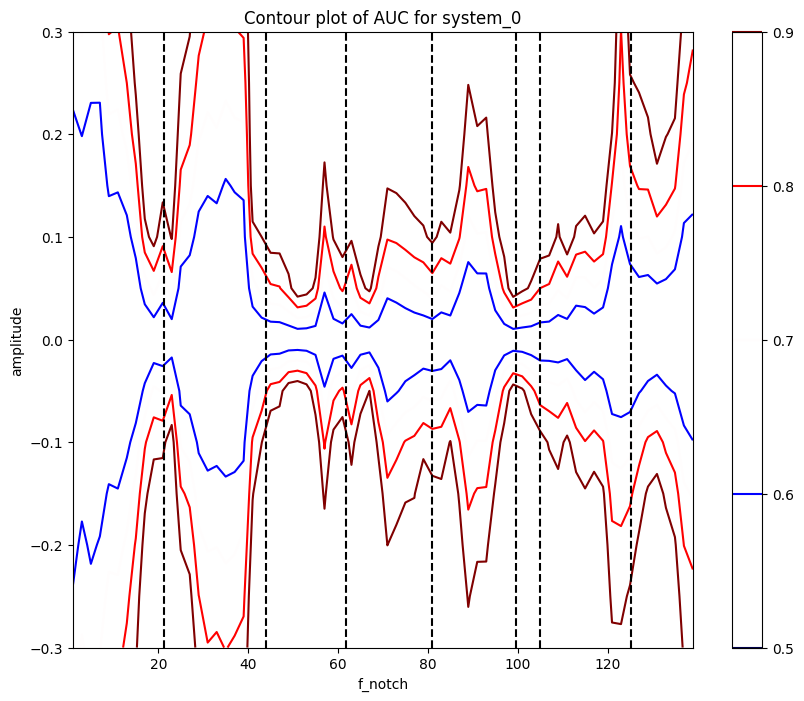

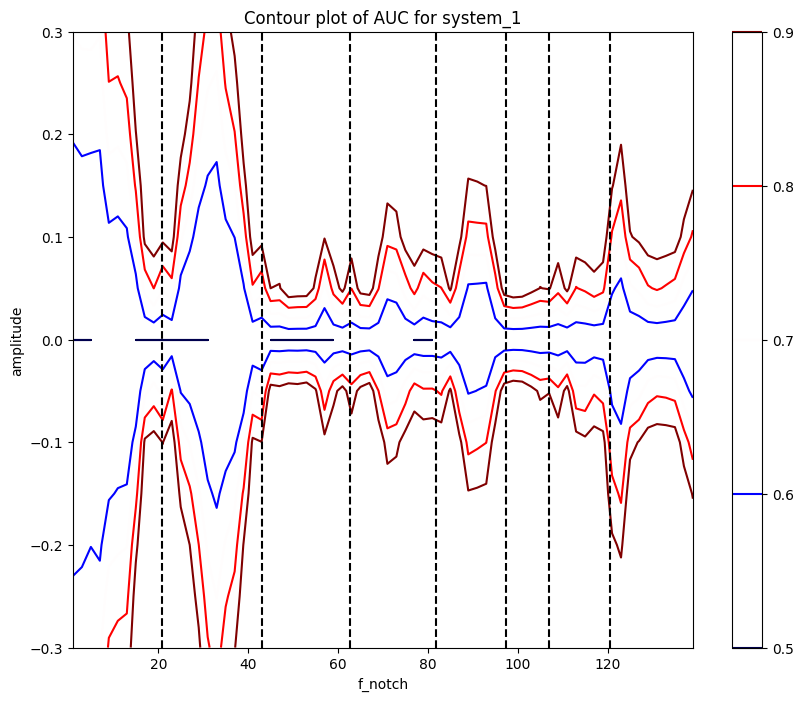

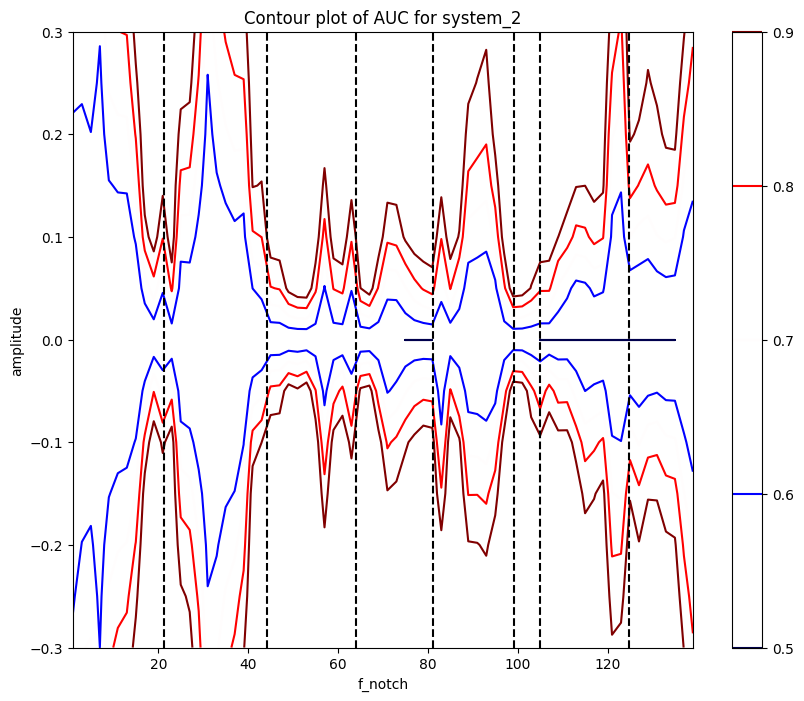

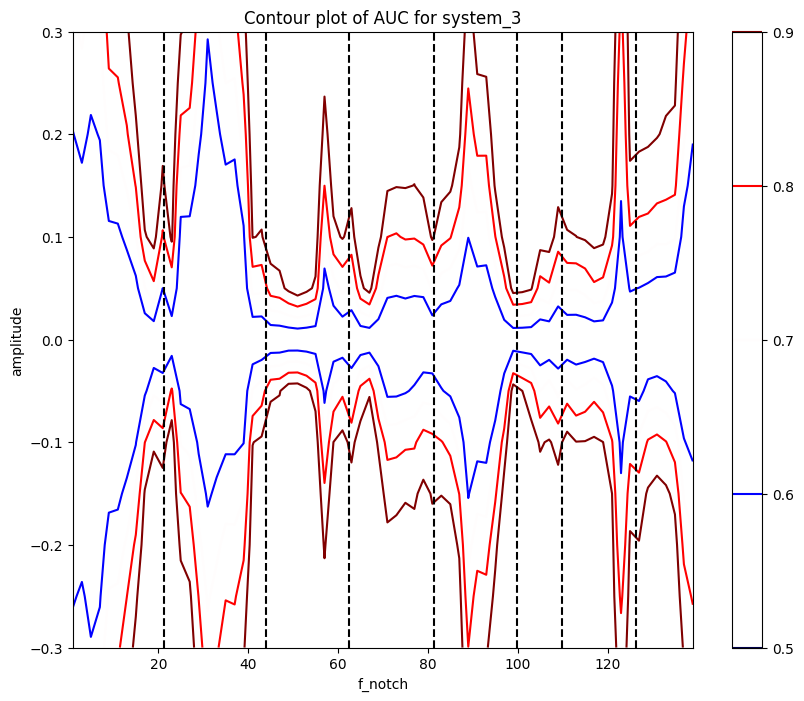

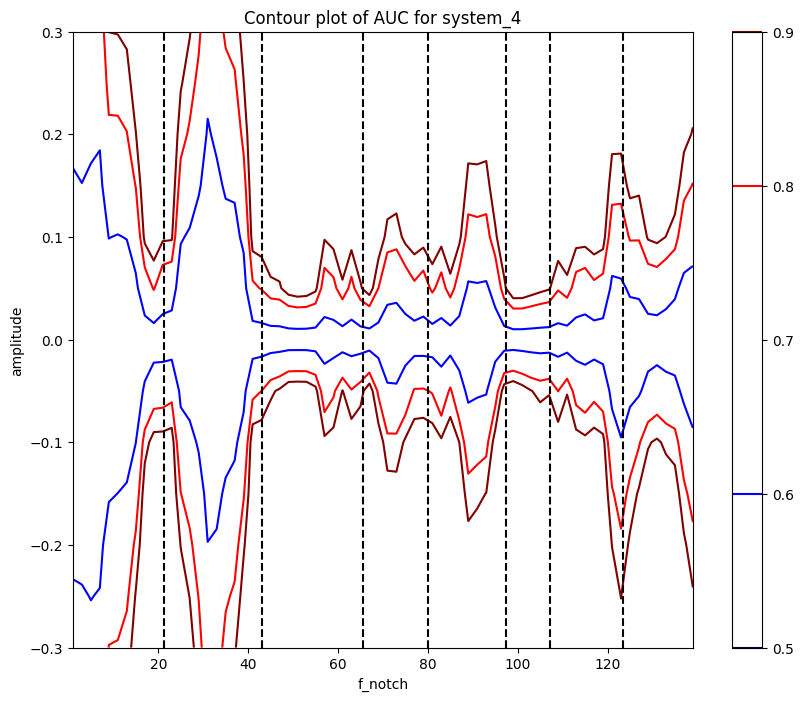

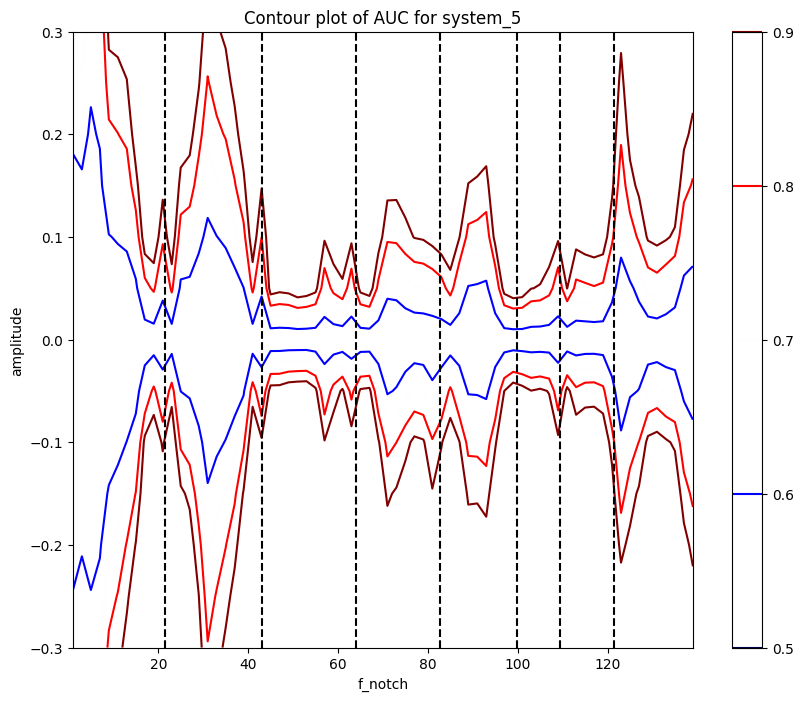

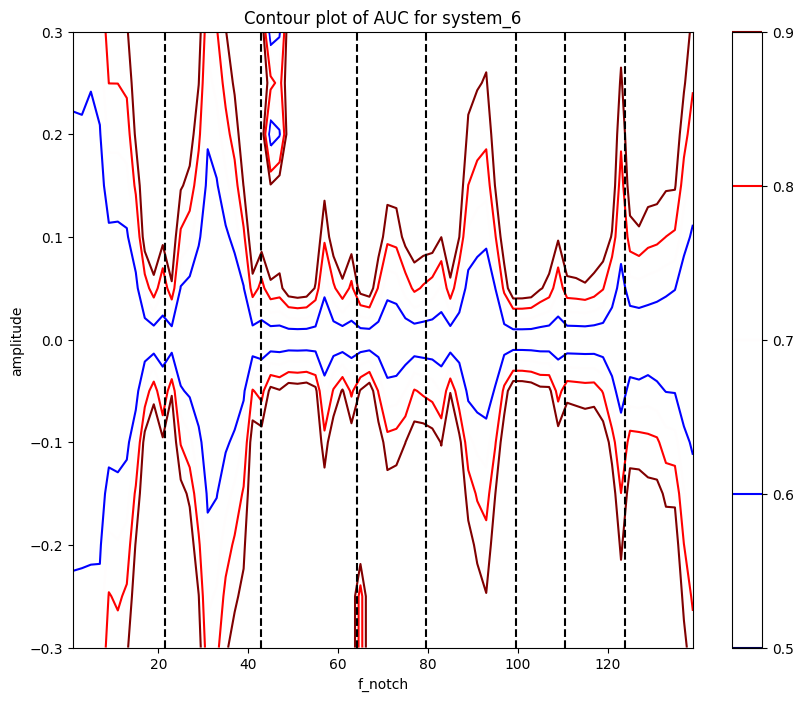

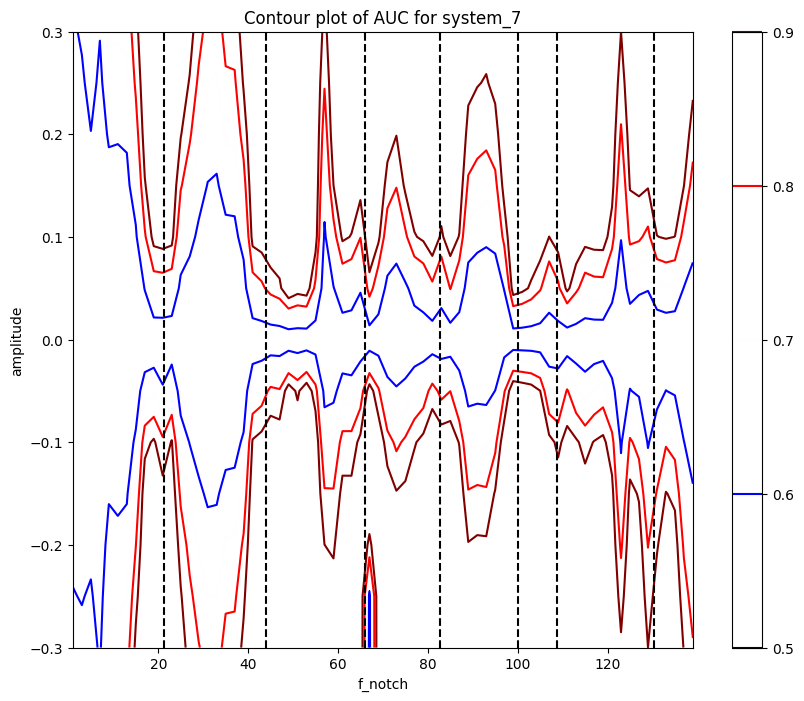

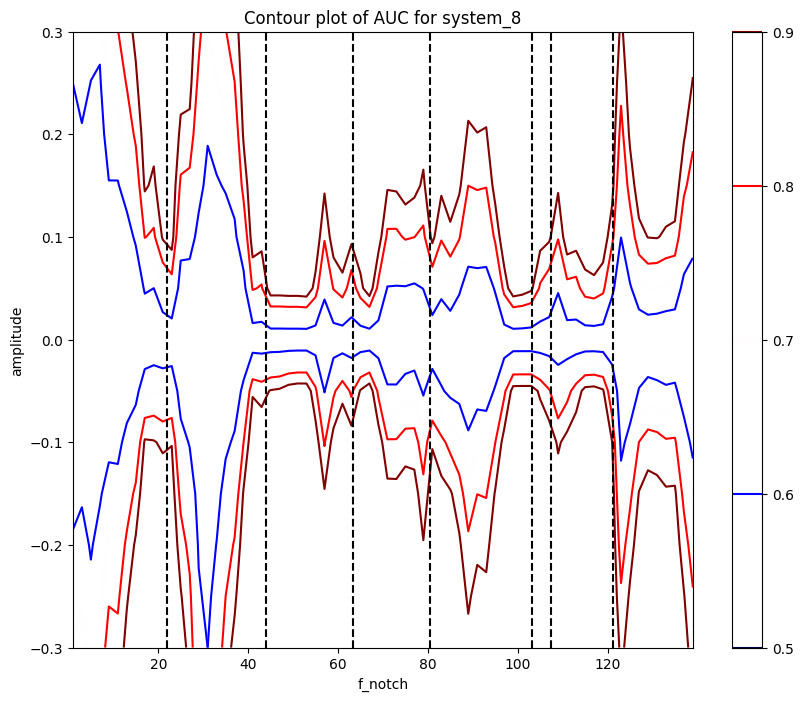

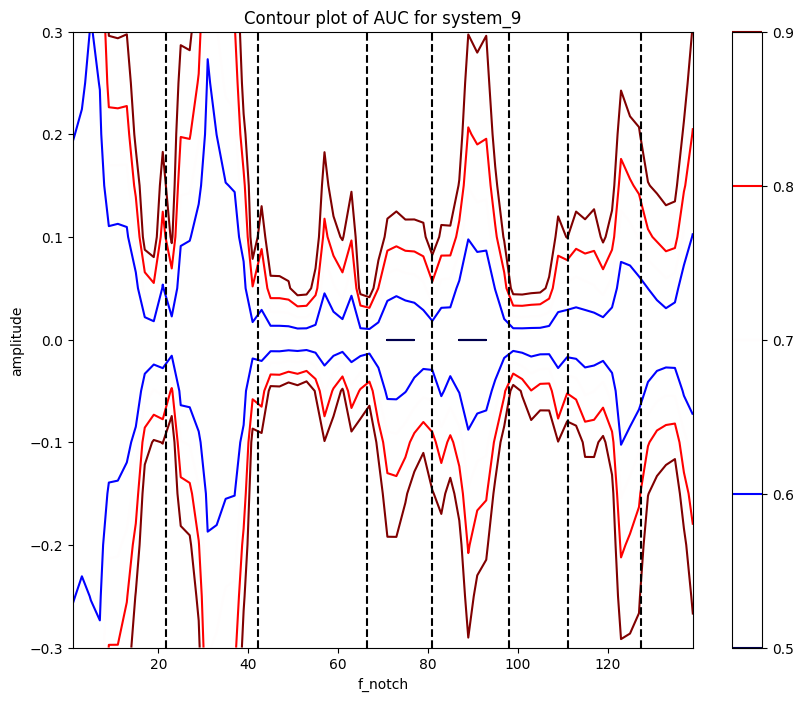

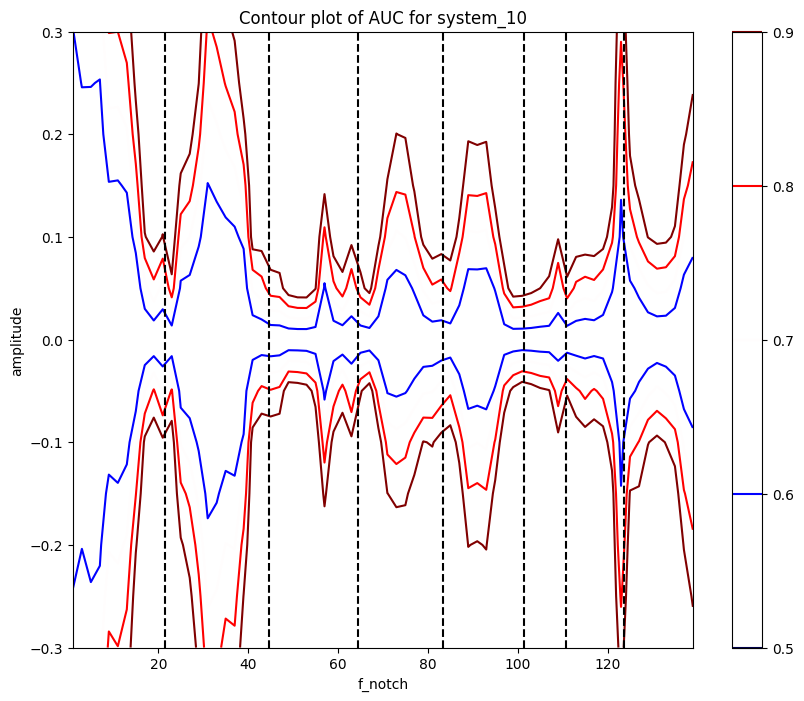

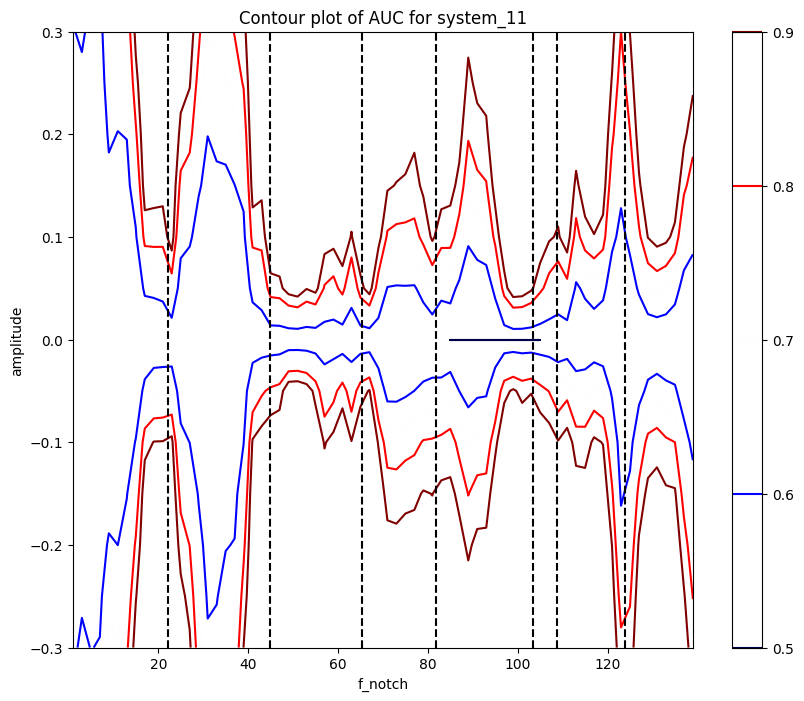

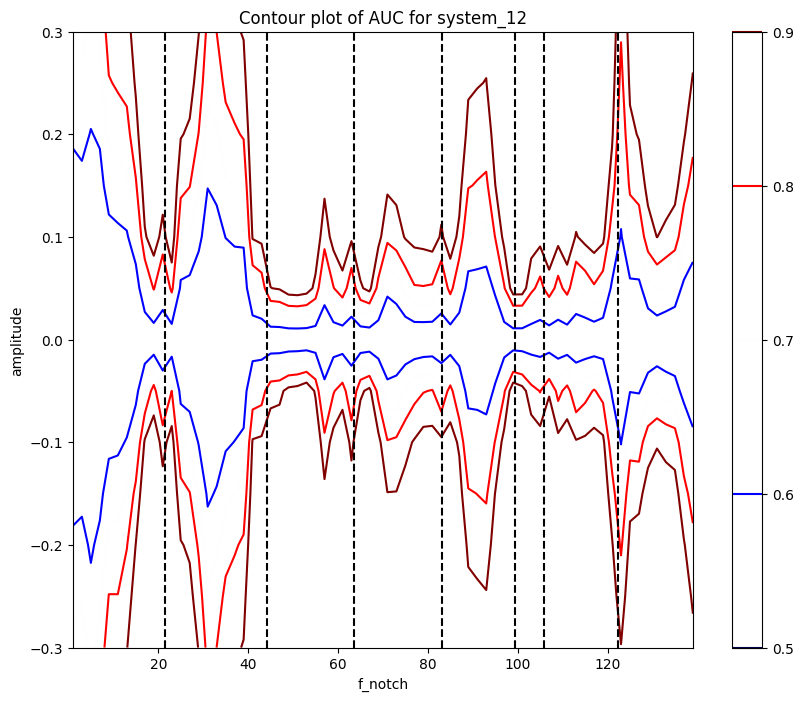

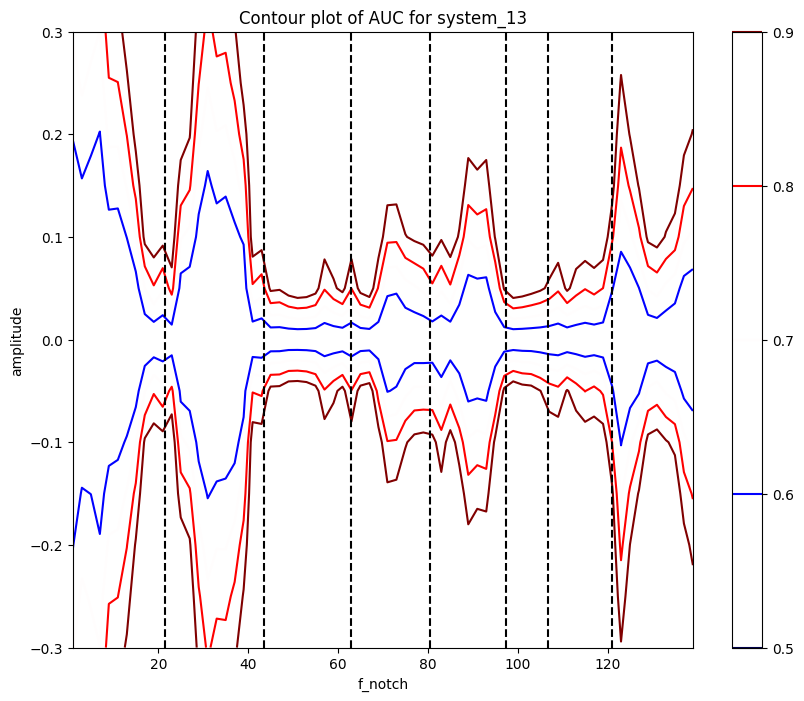

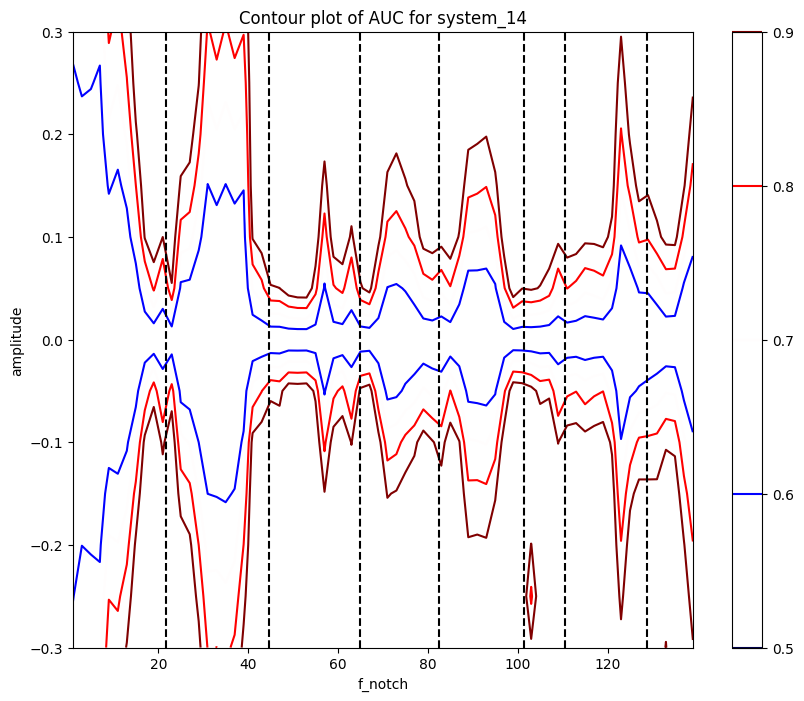

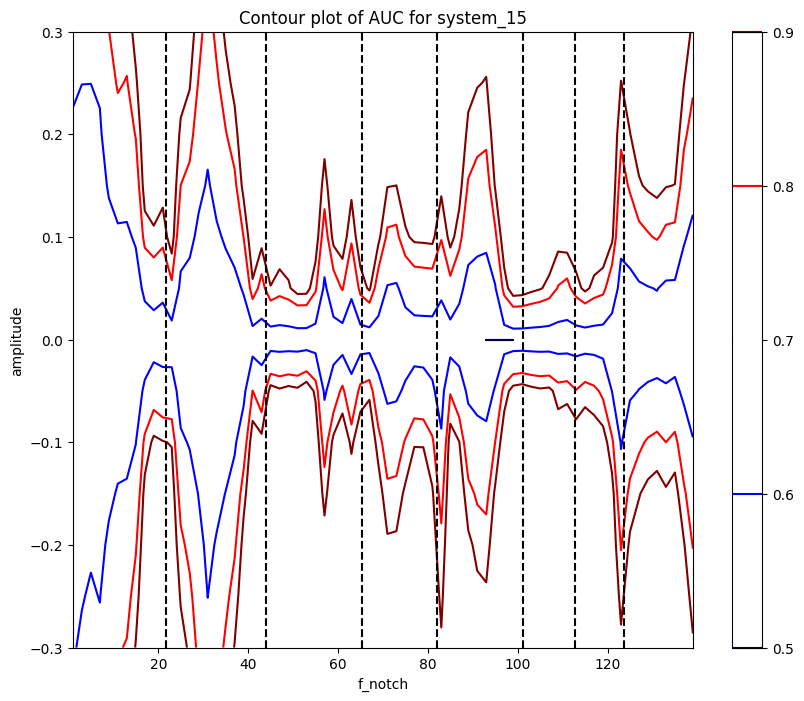

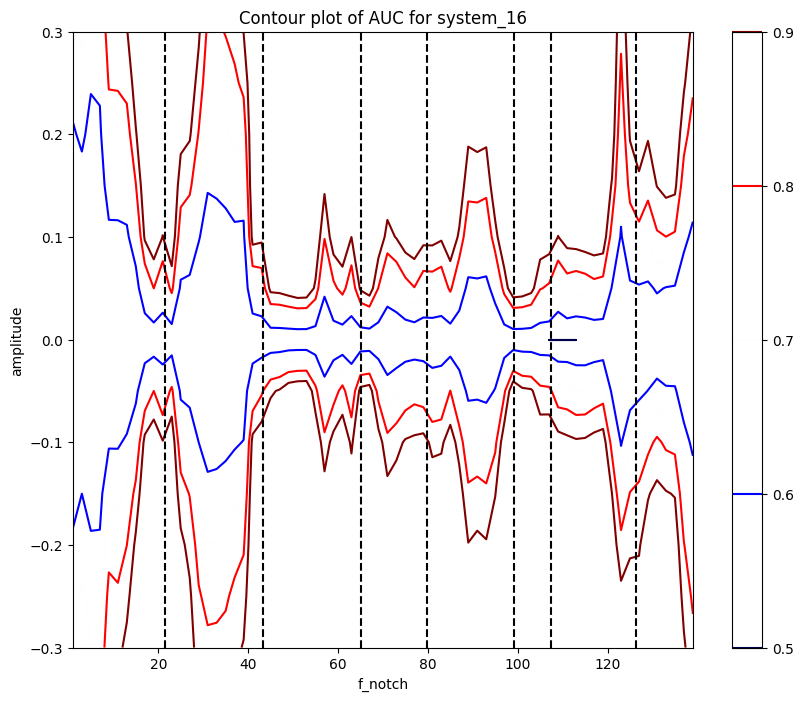

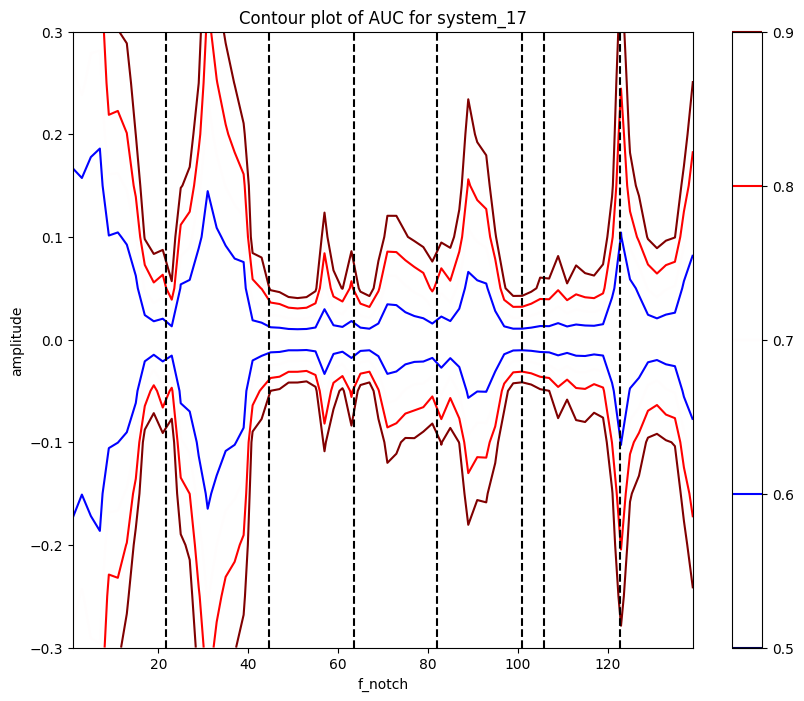

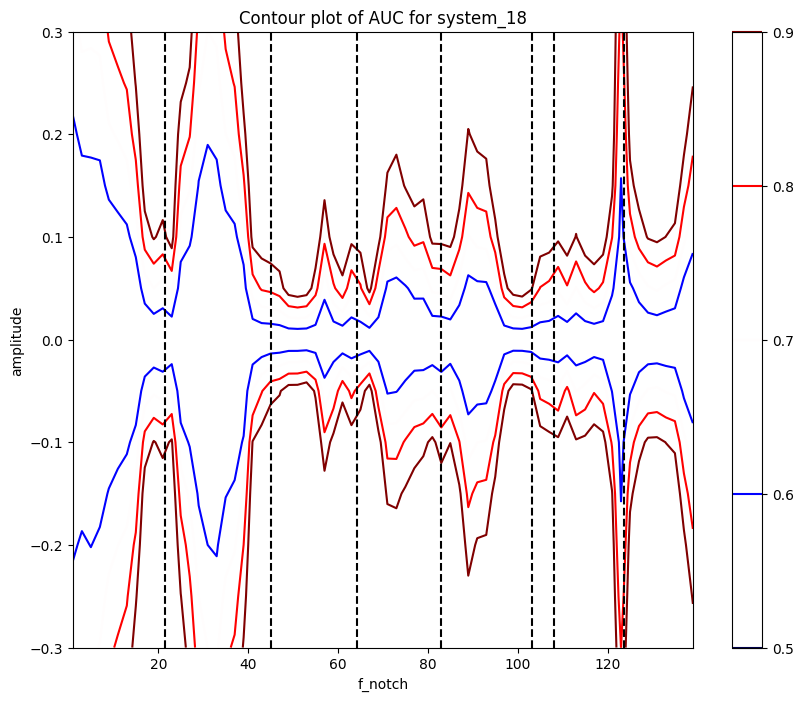

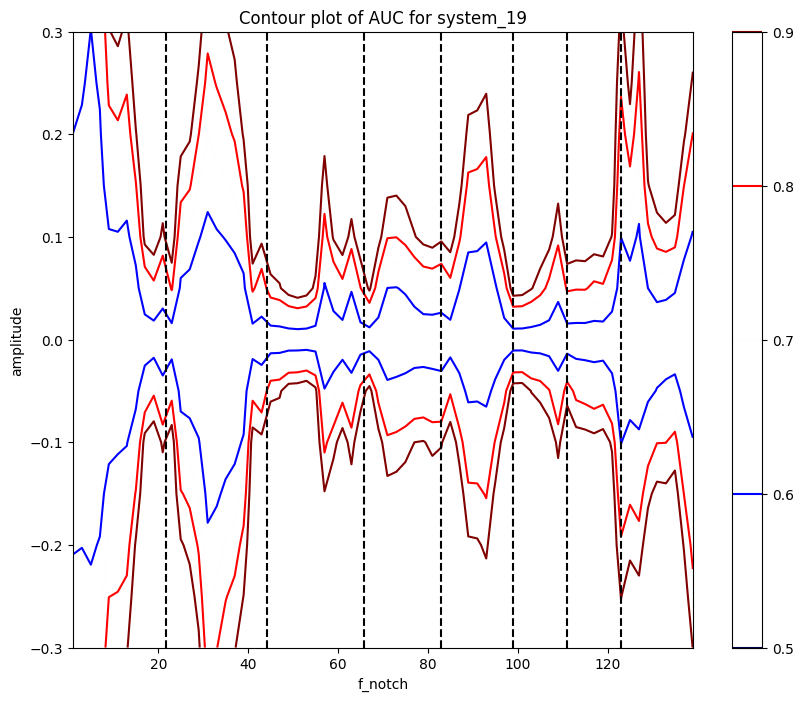

In [ ]:
# testing the class Benchmark_VAS
benchmark_vas = Benchmark_VAS(ad_system,psd_notch_dl,psd_notch_original_dl,batch_size=10000)
res = benchmark_vas.evaluate_all_systems()



In [ ]:
# testing the class Benchmark_VAS
df_auc= compute_auc_scores(res, system_number=0)

In [ ]:
df_heatmap

f_notch,1.0,3.0,5.0,7.0,9.0,11.0,13.0,15.0,17.0,19.0,21.0,23.0,25.0,27.0,29.0,31.0,33.0,35.0,37.0,39.0,41.0,43.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,59.0,61.0,63.0,65.0,67.0,69.0,71.0,73.0,75.0,77.0,79.0,81.0,83.0,85.0,87.0,89.0,91.0,93.0,95.0,97.0,99.0,101.0,103.0,105.0,107.0,109.0,111.0,113.0,115.0,117.0,119.0,121.0,123.0,125.0,127.0,129.0,131.0,133.0,135.0,137.0,139.0
amplitude,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-0.30,0.647,0.711,0.664,0.694,0.776,0.771,0.821,0.887,0.991,1.000,1.000,1.000,0.967,0.958,0.865,0.805,0.817,0.796,0.814,0.830,0.998,1.000,1.000,1.000,1.000,0.995,1.000,1.000,0.999,0.999,0.998,1.000,1.000,1.000,1.000,0.973,0.984,0.992,0.993,1.000,0.999,0.995,1.000,0.983,0.926,0.965,0.961,0.997,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,1.000,0.999,0.998,0.992,0.919,0.916,0.942,0.972,0.997,0.998,0.987,0.973,0.888,0.871
-0.25,0.608,0.665,0.623,0.650,0.727,0.724,0.777,0.857,0.970,0.999,0.998,1.000,0.941,0.924,0.801,0.753,0.761,0.739,0.755,0.781,0.986,1.000,0.999,0.998,1.000,0.971,1.000,1.000,0.982,1.000,0.999,0.998,1.000,1.000,0.999,0.942,0.959,0.975,0.970,0.999,0.992,0.982,0.999,0.960,0.893,0.932,0.930,0.988,1.000,1.000,1.000,1.000,1.000,1.000,0.990,1.000,0.998,0.992,0.993,0.985,0.880,0.880,0.910,0.948,0.985,0.992,0.970,0.949,0.852,0.831
-0.20,0.571,0.619,0.587,0.607,0.670,0.667,0.717,0.809,0.932,0.989,0.987,1.000,0.895,0.867,0.727,0.692,0.697,0.678,0.688,0.719,0.944,1.000,0.998,0.998,1.000,0.967,1.000,1.000,0.939,1.000,1.000,0.986,1.000,1.000,0.994,0.900,0.922,0.942,0.939,0.989,0.968,0.957,0.995,0.931,0.847,0.884,0.886,0.960,1.000,1.000,1.000,1.000,1.000,0.991,0.968,0.998,0.980,0.969,0.981,0.966,0.832,0.829,0.862,0.914,0.955,0.976,0.939,0.910,0.799,0.772
-0.15,0.541,0.577,0.557,0.567,0.610,0.605,0.650,0.736,0.880,0.947,0.953,0.997,0.818,0.775,0.651,0.627,0.635,0.619,0.624,0.646,0.894,0.983,1.000,1.000,1.000,0.999,1.000,1.000,0.884,0.995,1.000,0.946,1.000,1.000,0.957,0.834,0.867,0.891,0.896,0.954,0.928,0.918,0.963,0.892,0.779,0.811,0.814,0.913,0.995,1.000,1.000,1.000,0.995,0.957,0.929,0.979,0.935,0.911,0.943,0.915,0.763,0.750,0.780,0.859,0.913,0.935,0.885,0.844,0.721,0.691
-0.10,0.520,0.538,0.532,0.532,0.554,0.553,0.578,0.635,0.788,0.876,0.877,0.958,0.687,0.655,0.586,0.566,0.570,0.562,0.567,0.574,0.817,0.897,0.987,0.985,1.000,1.000,1.000,0.975,0.788,0.943,0.977,0.864,0.976,0.998,0.875,0.722,0.765,0.806,0.822,0.874,0.848,0.854,0.904,0.808,0.669,0.704,0.704,0.839,0.945,1.000,0.998,0.984,0.943,0.890,0.868,0.921,0.852,0.804,0.842,0.805,0.659,0.647,0.667,0.751,0.820,0.843,0.778,0.736,0.625,0.602
-0.05,0.504,0.512,0.513,0.511,0.515,0.515,0.524,0.541,0.618,0.719,0.693,0.787,0.565,0.554,0.529,0.520,0.520,0.518,0.519,0.522,0.642,0.738,0.845,0.864,0.973,0.995,0.959,0.835,0.609,0.767,0.820,0.681,0.838,0.900,0.682,0.568,0.592,0.623,0.644,0.677,0.664,0.674,0.748,0.627,0.552,0.561,0.559,0.667,0.825,0.958,0.919,0.830,0.746,0.741,0.725,0.763,0.667,0.627,0.659,0.629,0.552,0.551,0.553,0.593,0.624,0.646,0.612,0.593,0.549,0.536
0.00,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500
0.05,0.509,0.508,0.501,0.505,0.521,0.520,0.524,0.546,0.645,0.730,0.640,0.751,0.551,0.538,0.516,0.515,0.517,0.512,0.516,0.515,0.656,0.734,0.787,0.795,0.864,0.978,0.955,0.875,0.609,0.747,0.818,0.702,0.868,0.926,0.762,0.624,0.639,0.663,0.690,0.713,0.750,0.689,0.713,0.611,0.546,0.562,0.564,0.675,0.827,0.981,0.925,0.885,0.800,0.785,0.709,0.748,0.651,0.658,0.698,0.660,0.549,0.519,0.548,0.571,0.565,0.584,0.571,0.550,0.512,0.513
0.10,0.527,0.534,0.517,0.521,0.559,0.556,0.570,0.638,0.867,0.938,0.835,0.906,0.667,0.634,0.565,0.555,0.559,0.539,0.547,0.557,0.870,0.900,0.95

In [ ]:
aucs.shape

(12, 70)

In [ ]:
df_heatmap  
# compute the weighted mean of the auc using the absolute value of the amplitude as weight
# first remove the amplitude =0

weighted_mean_auc

0.7201006711145996

In [ ]:
df_heatmap = get_heatmap_data(df_auc)

15.79600607746459

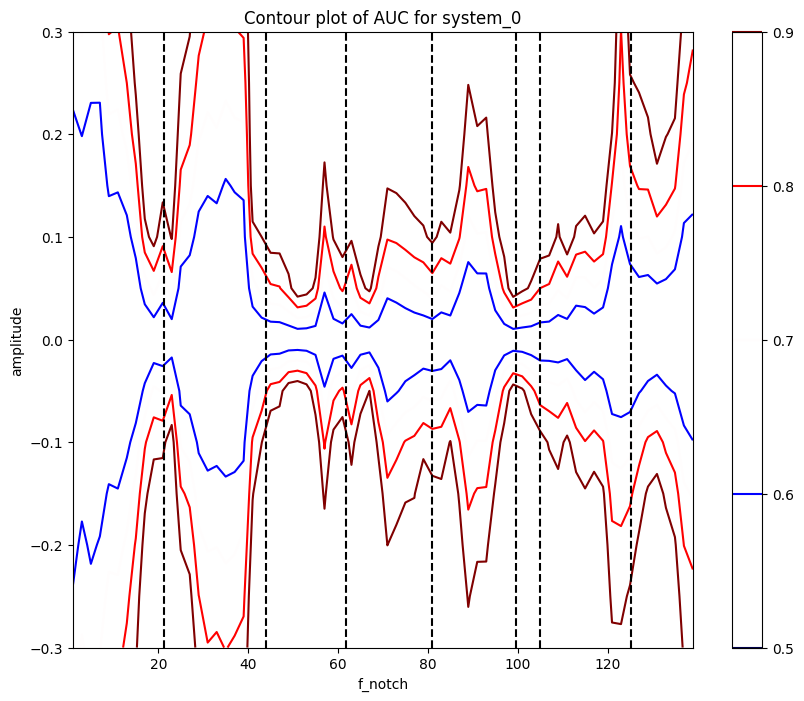

In [ ]:
ax,contour =plot_auc_contour(df_heatmap, "system_0")
compute_total_area(contour)

In [ ]:
axes = res[2]

In [ ]:
axes[0]


<Axes: title={'center': 'Contour plot of AUC for system_0'}, xlabel='f_notch', ylabel='amplitude'>